Task - Linear regression
Aim
Perform a linear regression analysis (of your slice) of the Instacart dataset, predicting the number of days between orders.

Detail
The problem to solve takes the form of Linear Regression with categorical independent variables.

Consider the sequence of orders placed by a customer. The hypothesis is that the typical product mix for that customer can be used to predict when the next order will be placed.

For training data, take an 80% subset of "relevant" orders, across all "relevant" users. From the first to the second last order, determine the product mix for that user, as well as the number of days until the next order for that user.

The training data is the remaining 20% subset of "relevant" orders, across all "relevant" users.

For example, if there were just 1 user and that user placed 11 orders, the training set could include the product mixes for each of the following 8 orders: 1, 2, 4, 5, 6, 7, 9, 10, together with the "days between orders" for each of the 8 order pairs (1,2), (2,3), (4,5), (5,6), (6,7), (7,8), (9,10), (10,11). In this case, the test data would include the product mix for order 3 and 8, together with the "days between orders" for each of the 2 order pairs (3,4) and (8,9).

Please note that the proposed 80:20 split is across user x order combinations.

Also, in practice, relevant implies an unbiased subset chosen to make the problem tractable with the computing resources available to each student.

For Independent variables, the product (mix) for order i-1 can be used, and the Dependent variable is the number of days between order i-1 and order i in that sequence for a given user.

Therefore the number of observations in the observation matrix is the number of users times the number of orders for each user.

Since there are 49688 distinct products, the dimensionality of the problem is very high, so students need to take account of this using:

roll up to aisle (134 unique) or department (21 unique) and build model accordingly
use PCA to reduce the dimensions (of products, aisles and/or departments), and solve using the reduced-dimension model
use regularisation and fit a constrained model.
Disclaimers/Comments
It is possible to obtain either per-user predictions (by solving a separate regression problem for each user) or a user-agnostic prediction (by merging the data for many users). It would be interesting to try both and compare, explaining what you find.

Much of this task relates to dimensionality reduction. In traditional BI, this would be done using roll-ups (e.g., from product to aisle), but linear regression offers other options. The BI approach is easier to interpret, because of the "meaningful" labels, but does it work as well? Give reasons for your answer!

Validating the results requires analysis of the outputs (and not just the predictions) of the linear regression model, e.g., R-squared and any other metrics you believe are helpful here.

Grading Outline
3 x 25% for each of the 3 regression model x dimensionality reduction options above, where the 25% consists of
5% Visualisation
10% formulation and solving
10% Validation/Comments/analysis.
25% for comparing per-user and multi-user models, and different methods for dimensionality reduction.

In [1]:
%matplotlib inline 

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
sns.set_context("paper")

from itertools import combinations, groupby
from collections import Counter
from mlxtend.preprocessing import TransactionEncoder
from sklearn import linear_model
import sys

In [28]:
orders_products_prior_full = pd.read_csv('instacart_2017_05_01/my_order_products__prior.csv')
orders_products_train_full = pd.read_csv('instacart_2017_05_01/my_order_products__train.csv')
orders_products = pd.concat([orders_products_prior_full, orders_products_train_full])
PRODUCT_KEEP_MIN_FREQ=3 #8 is top 11, 18 is top 40
c = orders_products["product_id"].value_counts().gt(PRODUCT_KEEP_MIN_FREQ)
top_products_df = orders_products.loc[orders_products["product_id"].isin(c[c].index)]
#lets find top 40 products
print(top_products_df["product_id"].nunique())

print(orders_products["product_id"].nunique())
orders = pd.read_csv('instacart_2017_05_01/my_orders.csv')
products = pd.read_csv('instacart_2017_05_01/products.csv')
aisles = pd.read_csv('instacart_2017_05_01/aisles.csv')
departments = pd.read_csv('instacart_2017_05_01/departments.csv')
tops_df = pd.merge(top_products_df,products,on='product_id', how='left').apply(lambda x: x)
top_product_names = tops_df["product_name"].unique()
top_products_df.head()

164
876


,Unnamed: 0,order_id,product_id,add_to_cart_order,reordered
0,83830,8938,49235,1,1
1,83831,8938,13032,2,1
2,83832,8938,26348,3,1
5,83835,8938,37710,6,1
7,333401,35204,8859,1,1


In [4]:
orders.head(n=20)


,Unnamed: 0,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,30650,3308693,1886,prior,1,4,8,NaN
1,30651,1019221,1886,prior,2,3,8,6.0
2,30652,3410026,1886,prior,3,3,10,7.0
3,30653,2727369,1886,prior,4,1,8,5.0
4,30654,94907,1886,prior,5,1,16,7.0
5,30655,3085430,1886,prior,6,1,9,7.0
6,30656,1463979,1886,prior,7,1,9,7.0
7,30657,1022421,1886,prior,8,4,16,3.0
8,30658,154497,1886,prior,9,4,13,7.0
9,30659,1953228,1886,prior,10,4,14,21.0


In [5]:
orders_products.head()

,Unnamed: 0,order_id,product_id,add_to_cart_order,reordered
0,83830,8938,49235,1,1
1,83831,8938,13032,2,1
2,83832,8938,26348,3,1
3,83833,8938,5028,4,1
4,83834,8938,15680,5,1


In [6]:
orders_a = pd.merge(orders, orders_products, on='order_id', how='inner').apply(lambda x: x)
orders_a.head()

,Unnamed: 0_x,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,Unnamed: 0_y,product_id,add_to_cart_order,reordered
0,30650,3308693,1886,prior,1,4,8,NaN,31370430,42972,1,0
1,30650,3308693,1886,prior,1,4,8,NaN,31370431,47977,2,0
2,30650,3308693,1886,prior,1,4,8,NaN,31370432,30696,3,0
3,30651,1019221,1886,prior,2,3,8,6.0,9655119,9623,1,0
4,30651,1019221,1886,prior,2,3,8,6.0,9655120,35914,2,0


In [7]:
columns = ['order_id', 'user_id', 'days_since_prior_order', 'product_id']
raw_data = pd.DataFrame(orders_a, columns=columns)
raw_data = pd.merge(raw_data, products, on='product_id', how='left').apply(lambda x: x)
raw_data = pd.merge(raw_data, aisles, on='aisle_id', how='left').apply(lambda x: x)
raw_data = pd.merge(raw_data, departments, on='department_id', how='left').apply(lambda x: x)
raw_data.head()

,order_id,user_id,days_since_prior_order,product_id,product_name,aisle_id,department_id,aisle,department
0,3308693,1886,NaN,42972,Natural Pure Sparkling Water,115,7,water seltzer sparkling water,beverages
1,3308693,1886,NaN,47977,Grapefruit Sparkling Water,115,7,water seltzer sparkling water,beverages
2,3308693,1886,NaN,30696,Eggo Homestyle Waffles,52,1,frozen breakfast,frozen
3,1019221,1886,6.0,9623,Sparkling Natural Spring Water,115,7,water seltzer sparkling water,beverages
4,1019221,1886,6.0,35914,Dha Omega 3 Reduced Fat 2% Milk,84,16,milk,dairy eggs


In [8]:
orders_ids = raw_data.order_id.unique()
list_of_maps = []

#for order_id in orders_ids:
for i, order_id in enumerate(orders_ids[:-1]):
    order_map = {}    
    inner_list = raw_data.loc[raw_data['order_id'] == order_id, ['user_id','product_name','days_since_prior_order']]
    next_df = raw_data.loc[raw_data['order_id'] == orders_ids[i+1], ['user_id','days_since_prior_order']]
    next_user_id = next_df["user_id"].unique()[0]
    this_user_id = inner_list["user_id"].unique()[0]
   
    order_map['order_id'] = order_id
    order_map['user_id'] = this_user_id
    for top_prod in top_product_names:
        value = '1' if (top_prod in list(inner_list["product_name"])) else '0'
        order_map[top_prod] = value
        

    order_map['product_mix'] = set([x if (x in top_product_names) else 'Other' for x in inner_list["product_name"]])
    if this_user_id == next_user_id :
        order_map['days_since_prior_order'] = next_df['days_since_prior_order'].unique()[0]
    list_of_maps.append(order_map)
    
df_timeline_all_users = pd.DataFrame(list_of_maps, columns=list_of_maps[0].keys())
df_timeline_all_users.head(n=30)

,order_id,user_id,Organic Half & Half,Cinnamon Toast Crunch,Mixed Fruit Fruit Snacks,Trail Mix,Natural Spring Water,Pure Irish Butter,Organic Salted Butter,Dried Mango,...,Deli Fresh Shaved Smoked Turkey Breast,Original Orange Juice,Organic Baby Arugula,Peach on the Bottom Nonfat Greek Yogurt,Pretzel Crisps Original Deli Style Pretzel Crackers,Boneless And Skinless Chicken Breast,Light Mozzarella String Cheese,French Vanilla Creamer,product_mix,days_since_prior_order
0,3308693,1886,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"{Grapefruit Sparkling Water, Natural Pure Spar...",6.0
1,1019221,1886,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"{Other, Wasabi & Soy Sauce Almonds, Dha Omega ...",7.0
2,3410026,1886,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"{Dha Omega 3 Reduced Fat 2% Milk, Grapefruit S...",5.0
3,2727369,1886,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"{Grapefruit Sparkling Water, Natural Pure Spar...",7.0
4,94907,1886,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"{Cran-Raspberry Flavored Sparkling Water, Orga...",7.0
5,3085430,1886,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"{Grapefruit Sparkling Water, Bold Habanero BBQ...",7.0
6,1463979,1886,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"{Grapefruit Sparkling Water, Bold Habanero BBQ...",3.0
7,1022421,1886,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"{Other, Wasabi & Soy Sauce Almonds, Natural Pu...",7.0
8,154497,1886,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"{Cran-Raspberry Flavored Sparkling Water, Orga...",21.0
9,1953228,1886,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"{Cran-Raspberry Flavored Sparkling Water, Orga...",7.0


lets try for one user

In [9]:
columns = ['product_mix', 'days_since_prior_order']
#raw_data = pd.DataFrame(orders_a, columns=columns)
df_1886 = df_timeline_all_users.loc[df_timeline_all_users["user_id"] == 5485]
df_1886

,order_id,user_id,Organic Half & Half,Cinnamon Toast Crunch,Mixed Fruit Fruit Snacks,Trail Mix,Natural Spring Water,Pure Irish Butter,Organic Salted Butter,Dried Mango,...,Deli Fresh Shaved Smoked Turkey Breast,Original Orange Juice,Organic Baby Arugula,Peach on the Bottom Nonfat Greek Yogurt,Pretzel Crisps Original Deli Style Pretzel Crackers,Boneless And Skinless Chicken Breast,Light Mozzarella String Cheese,French Vanilla Creamer,product_mix,days_since_prior_order
27,1011779,5485,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"{Other, Large Lemon, Lime}",30.0
28,333779,5485,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"{Cucumber Kirby, Organic Baby Carrots, Organic...",30.0
29,2076621,5485,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,{Other},9.0
30,420648,5485,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"{Other, Tortilla Chips, Clasico, Jalapeno Lime}",11.0
31,2038243,5485,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"{Organic Yellow Onion, Organic White Chocolate...",10.0
32,1968246,5485,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"{Other, Tortilla Chips, Clasico, Jalapeno Lime}",11.0
33,1282427,5485,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"{Organic Chicken Broth, Organic Baby Carrots, ...",17.0
34,1373808,5485,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"{Other, Organic Tomato Cluster}",29.0
35,1732888,5485,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"{Organic Tomato Cluster, Organic White Chocola...",17.0
36,132974,5485,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"{Organic Red Onion, Limes, Organic Hass Avocad...",6.0


this would be too many columns

In [10]:
#y = data['Balance'].copy() # this is the Credit Balance vector - our 'y' vector
#X = data.copy()
#X.drop(['Balance'], axis=1, inplace=True) # X is a co
#df_timeline_all_users.head()


y = df_timeline_all_users["days_since_prior_order"].fillna("0").copy()
X = df_timeline_all_users.copy()
X.drop(['order_id','user_id','product_mix','days_since_prior_order'], axis=1, inplace=True)
X.head()


,Organic Half & Half,Cinnamon Toast Crunch,Mixed Fruit Fruit Snacks,Trail Mix,Natural Spring Water,Pure Irish Butter,Organic Salted Butter,Dried Mango,Apple Honeycrisp Organic,Banana,...,Total 2% Greek Strained Yogurt with Cherry 5.3 oz,Real Mayonnaise,Deli Fresh Shaved Smoked Turkey Breast,Original Orange Juice,Organic Baby Arugula,Peach on the Bottom Nonfat Greek Yogurt,Pretzel Crisps Original Deli Style Pretzel Crackers,Boneless And Skinless Chicken Breast,Light Mozzarella String Cheese,French Vanilla Creamer
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [11]:
model = linear_model.LinearRegression()
def findNextBestPredictor(X,foundPredictors):
    nP = X.shape[1] # number of columns in X
    allPredictors = list(X) # See https://stackoverflow.com/a/19483025
    predictorsToSearch = set(allPredictors) - set(foundPredictors)
    maxScore = 0 # can usually do better than this!
    for predictor in predictorsToSearch: # loop over all remaining columns (predictors) in X
        trialPredictors = set(foundPredictors)
        trialPredictors.add(predictor) # Add this predictor to the existing predictors
        XcolSubset = X.loc[:,trialPredictors] # all rows and just the trial predictors
        #print(y)
        model.fit(XcolSubset, y) # fit the model to y
        score = model.score(XcolSubset, y)
        if score > maxScore: # identify the largest score and its associated predictor
            maxScore = score
            bestPredictorFound = predictor

    return (maxScore, bestPredictorFound)

findNextBestPredictor(X, list())

(0.04628176343840562, 'Original Orange Juice')

In [12]:
nP = X.shape[1]
scores = [0]
foundPredictors = list()

for i in range(nP): # loop over all columns (predictors) in X
    (score, bestPredictorFound) = findNextBestPredictor(X, foundPredictors)
    foundPredictors.append(bestPredictorFound)
    scores.append(score)

print(foundPredictors)
print(scores)

['Original Orange Juice', 'Organic Half & Half', 'XL Pick-A-Size Paper Towel Rolls', 'Penne Pasta', 'Purified Water', 'Bathroom Tissue', 'Lime', 'Organic Chicken Broth', 'Almond Breeze Unsweetened Almond Coconut Milk Blend', 'Organic Tomato Cluster', 'Brown Extra Large Grade AA Eggs', 'Zero Rise Orange', 'Organic Chicken Stock', 'Soft & Smooth Whole Grain White Bread', 'Hampshire 100% Natural Sour Cream', 'Organic Reduced Fat 2% Milk', 'Natural Pure Sparkling Water', 'Organic Hass Avocado', 'Dried Mango', 'Organic Salted Butter', 'Organic Celery Hearts', 'Strawberries', 'Real Mayonnaise', 'Cruisers Diapers Jumbo Pack - Size 5', 'Smartwater', "M&M's Vanilla Lowfat Yogurt", 'Milano', 'Organic Mini Sweet Pepper, Pint', 'Sweet Onions', 'Wastebasket Liners', 'Cinnamon Toast Crunch', 'Chocolate Chip Cookies', 'French Vanilla Creamer', 'Light Mozzarella String Cheese', 'Large Lemon', '3 Toddler Next Step Natural Milk Flavor Milk Drink', 'Whole Milk', 'Organic Plain Cream on Top Yogurt', 'Orga

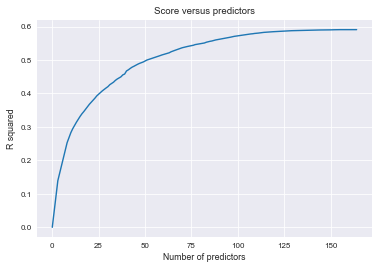

In [13]:
plt.title("Score versus predictors")
plt.xlabel('Number of predictors') 
plt.ylabel('R squared')
plt.plot(scores)

In [15]:
#from sklearn.feature_selection import RFE #https://machinelearningmastery.com/feature-selection-machine-learning-python/
#from sklearn.linear_model import LogisticRegression
#from sklearn.decomposition import PCA
#pca = PCA(n_components=3)
#fit = pca.fit(X)
#print(fit)
from sklearn import preprocessing

scaler = preprocessing.StandardScaler()
scaledXarray = scaler.fit_transform(X) # Note that X is no longer a dataframe after scaling :-(
scaledX = pd.DataFrame(scaledXarray, index=X.index, columns=X.columns) # Convert it back
model.fit(scaledX, y)
predictors = scaledX.columns
coef = pd.Series(model.coef_,predictors).sort_values(ascending=False)
coef

Chocolate Sea Salt                                                   7.615195e+13
Cinnamon Swirl Raisin Bread                                          9.745385e+12
Organic Baby Arugula                                                 4.112951e+00
Organic Nectarine                                                    3.500454e+00
Penne Pasta                                                          3.472927e+00
Organic Half & Half                                                  2.178077e+00
Nine Grain Sourdough Dough                                           1.883636e+00
Apple Honeycrisp Organic                                             1.839206e+00
Cran-Raspberry Flavored Sparkling Water                              1.829413e+00
Whole Milk                                                           1.725333e+00
Organic Strawberries                                                 1.626375e+00
XL Pick-A-Size Paper Towel Rolls                                     1.618328e+00
Organic Mini Swe

## ROLL UP ATTEMPT

In [ ]:
orders_ids = raw_data.order_id.unique()
list_of_maps = []

#for order_id in orders_ids:
for i, order_id in enumerate(orders_ids[:-1]):
    order_map = {}    
    inner_list = raw_data.loc[raw_data['order_id'] == order_id, ['user_id','product_name','days_since_prior_order']]
    next_df = raw_data.loc[raw_data['order_id'] == orders_ids[i+1], ['user_id','days_since_prior_order']]
    next_user_id = next_df["user_id"].unique()[0]
    this_user_id = inner_list["user_id"].unique()[0]
   
    order_map['order_id'] = order_id
    order_map['user_id'] = this_user_id
    for top_prod in top_product_names:
        value = '1' if (top_prod in list(inner_list["product_name"])) else '0'
        order_map[top_prod] = value
        

    order_map['product_mix'] = set([x if (x in top_product_names) else 'Other' for x in inner_list["product_name"]])
    if this_user_id == next_user_id :
        order_map['days_since_prior_order'] = next_df['days_since_prior_order'].unique()[0]
    list_of_maps.append(order_map)
    
df_timeline_all_users = pd.DataFrame(list_of_maps, columns=list_of_maps[0].keys())
df_timeline_all_users.head(n=30)